# 1. Word2Vec
1. 등장배경
    - 대규모 말뭉치를 다룰 때 메모리상의 문제가 발생
    - 한 번에 학습 데이터 전체를 진행함
    - 학습을 통해서 개선하기가 어려움<br><br>

2. 정의
    - Word2Vec은 단어간 유사도를 반영하여 단어를 벡터로 바꿔주는 임베딩 방법론이다. 원-핫벡터 형태의 sparse matrix가 가지는 단점을 해소하고자 저차원의 공간에 벡터로 매핑하는 것이 특징이다. Word2Vec은 "비슷한 위치에 등장하는 단어들은 비슷한 의미를 가진다"라는 가정을 통해서 학습을 진행한다. 저차원에 학습된 단어의 의미를 분산하여 표현하기에 단어 간 유사도를 계산할 수 있다.<br><br>
    - 추천 시스템에서는 단어를 구매 상품으로 바꿔서 구매한 패턴에 Word2Vec을 적용해서 비슷한 상품을 찾을 수 있다.<br><br>
    
3. 특징
    - 추론 기반의 방법
    - 추론 : **주변 단어(맥락)**이 주어졌을 때 "?"에 무슨 단어(중심단어)가 들어가는지를 추측하는 작업
    - 잘못 예측한 경우 학습을 통해서 점점 모델을 개선

**<p style="font-size:20px">Word2Vec - CBOW</p><br>**
CBOW는 주변에 있는 단어들을 가지고, 중간에 있는 단어들을 예측하는 방법이다. 반대로, Skip-Gram은 중간에 있는 단어로 주변 단어들을 예측하는 방법이다.

> 예) you say goodbye and I say hello.

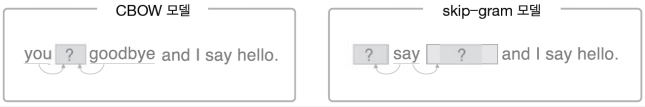
- 주변 단어 : 주변에 있는 단어 (you, goodbye)
- 중심 단어 : 중간에 있는 단어 (say)
- 윈도우 크기 : 주변을 몇 칸까지 볼 지에 대한 크기 (1)

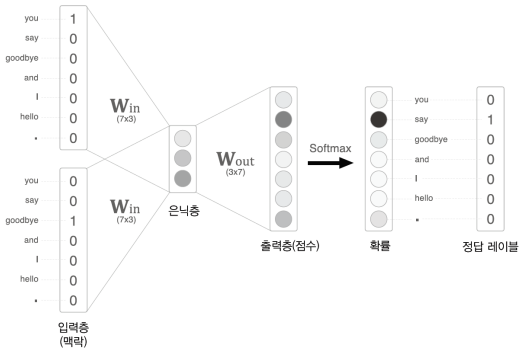

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

In [2]:
import warnings
warnings.filterwarnings(action = 'ignore')

In [3]:
movie = pd.read_csv('./dataset/ratings.csv', low_memory=False)
movie.head(2)

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435


In [4]:
# 시간순으로 정렬해주는 함수 sort_values 사용
movie = movie.sort_values(by='timestamp', ascending=True).reset_index(drop=True)
movie.head()

,userId,movieId,rating,timestamp
0,38150,1176,4.0,789652004
1,44717,1079,3.0,789652009
2,44717,47,5.0,789652009
3,44717,21,3.0,789652009
4,190860,21,5.0,822873600


In [5]:
# 영화의 Metadata를 불러와서 movieId에 맞는 title을 구해준다.
meta = pd.read_csv('./dataset/movies_metadata.csv', low_memory=False)
meta.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [6]:
meta.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [7]:
meta = meta.rename(columns = {'id' : 'movieId'}) # 컬럼명 변경
movie['movieId'] = movie['movieId'].astype(str)
meta['movieId'] = meta['movieId'].astype(str)

movie = pd.merge(movie, meta[['movieId', 'original_title']], how='left', on='movieId') # 조인

In [8]:
movie.head()

,userId,movieId,rating,timestamp,original_title
0,38150,1176,4.0,789652004,NaN
1,44717,1079,3.0,789652009,NaN
2,44717,47,5.0,789652009,NaN
3,44717,21,3.0,789652009,The Endless Summer
4,190860,21,5.0,822873600,The Endless Summer


In [9]:
movie = movie[movie['original_title'].notnull()].reset_index(drop=True)

In [10]:
agg = movie.groupby(['userId'])['original_title'].agg({'unique'})
agg.head()

,unique
userId,
1,"[Young and Innocent, Shuang ma lian huan, Cesa..."
2,"[La passion de Jeanne d'Arc, La belle et la bê..."
3,"[I Love You to Death, Once Were Warriors, Mons..."
4,"[Muxmäuschenstill, Batman & Robin, Hidalgo, 12..."
5,"[Star Trek III: The Search for Spock, The Curs..."


In [11]:
movie['original_title'].unique()

array(['The Endless Summer', 'Apocalypse Now', 'Finding Nemo', ...,
       'Lost River', 'Friends & Lovers', 'The Chechahcos'], dtype=object)

Wrod2Vec 적용

In [12]:
# int 형식은 Word2Vec에서 학습이 안되어서 String으로 변경해준다.
sentence = []
for user_sentence in agg['unique'].values:
    # map -> list 내의 모든 원소에 대해서 string으로 변환
    sentence.append(list(map(str, user_sentence)))

In [13]:
sentence[:20]

[['Young and Innocent',
  'Shuang ma lian huan',
  'Cesare deve morire',
  'Sleepless in Seattle',
  'Trois couleurs : Rouge',
  'Rocky Balboa',
  'License to Wed',
  'Confession of a Child of the Century',
  'Fools Rush In',
  'Shriek If You Know What I Did Last Friday the Thirteenth',
  'Les Quatre Cents Coups'],
 ["La passion de Jeanne d'Arc",
  'La belle et la bête',
  'Donnie Darko',
  'Jarhead',
  'Four Rooms',
  'The 39 Steps',
  'Almost Famous',
  'Mrs. Doubtfire',
  '英雄',
  'Monty Python and the Holy Grail',
  'Interview with the Vampire',
  "Pirates of the Caribbean: Dead Man's Chest",
  'Hable con ella',
  'The Matrix Revolutions',
  'Parenthood',
  'A Nightmare on Elm Street',
  'Night on Earth'],
 ['I Love You to Death',
  'Once Were Warriors',
  'Monsoon Wedding',
  'Reservoir Dogs',
  'Sleepless in Seattle',
  'The Third Man',
  'My Super Ex-Girlfriend',
  'Fools Rush In'],
 ['Muxmäuschenstill',
  'Batman & Robin',
  'Hidalgo',
  '12 + 1',
  'Tuya de hun shi',
  'Reign O

In [14]:
from gensim.models import Word2Vec

embedding_model = Word2Vec(sentence, size=20, window=5,
                          min_count=1, workers=4, iter=200, sg=1)  # sg : 0 - CBOW / sg : 1 - SKIP-GRAM

In [15]:
embedding_model.wv.most_similar(positive=['Spider-Man 2'], topn=10)

[('The Flintstones', 0.9302060604095459),
 ('Solaris', 0.921411395072937),
 ('To Die For', 0.9154757261276245),
 ('Chill Factor', 0.9115610122680664),
 ('Lammbock', 0.9002184867858887),
 ('Domicile Conjugal', 0.8921889066696167),
 ('Les Poupées Russes', 0.881050705909729),
 ('Flatliners', 0.8742765188217163),
 ('Forrest Gump', 0.8700658082962036),
 ('Land of Plenty', 0.8556262850761414)]

# 2. 콘텐츠 기반 모델 - 장단점
1. 장점
    - 협업 필터링은 다른 사용자들의 평점이 필요한 반면에, 자신의 평점만을 가지고 추천 시스템을 만들 수 있음.
    - item의 feature를 통해서 추천을 하기에 추천이 된 이유를 설명하기에 용이함
    - 사용자가 평점을 매기지 않은 새로운 item이 들어올 경우에도 추천이 가능함<br><br>
    
2. 단점
    - item의 feature을 추출해야 하고 이를 통해서 추천하기 때문에 제대로 feature를 추출하지 못하면 정확도가 낮음. 그렇기에 Domain Knowleadge가 분석시에 필요할 수도 있음
    - 기존의 item과 유사한 item 위주로만 추천하기에 새로운 장르의 item을 추천하기 어려움
    - 새로운 사용자에 대해서 충분한 평점이 쌓이기 전까지는 추천하기 힘듦